In [ ]:
import pandas as pd
import numpy as np
import scipy.io as sio
import io

In [ ]:
!wget http://csegroups.case.edu/sites/default/files/bearingdatacenter/files/Datafiles/97.mat
!wget http://csegroups.case.edu/sites/default/files/bearingdatacenter/files/Datafiles/98.mat
!wget http://csegroups.case.edu/sites/default/files/bearingdatacenter/files/Datafiles/99.mat
!wget http://csegroups.case.edu/sites/default/files/bearingdatacenter/files/Datafiles/100.mat

In [ ]:
!mkdir cwr_healthy

In [ ]:
!mv *.mat cwr_healthy

In [ ]:
!ls -l cwr_healthy

In [ ]:
mlf = sio.loadmat('cwr_healthy/100.mat')
print(mlf)
print(mlf.keys())
mlf['X100_DE_time'].size


In [ ]:
def read_folder(folder):
    data = 'dummy'
    skip = False
    for file in os.listdir(folder):
        file_id = file[:-4]
        mat_file_dict = sio.loadmat(folder+file)
        del data
        for key, value in mat_file_dict.items():
            if 'DE_time' in key or 'FE_time' in key:
                a = np.array(mat_file_dict[key])
                try:
                    data
                except NameError:
                    data = a
                else:
                    if (data.shape[0] != a.shape[0]):
                        print ('skipping ' + file_id)
                        skip = True
                        continue
                    data = np.hstack((data,a))
        if skip:
            skip=False
            continue
        id = np.repeat(file_id,data.shape[0])
        id.shape = (id.shape[0],1)
        data = np.hstack((id,data))
        if data.shape[1] == 2:
            zeros = np.repeat(float(0),data.shape[0])
            zeros.shape =(data.shape[0],1)
            data = np.hstack((data,zeros))
        try:
            result
        except NameError:
            result = data
        else:
            result = np.vstack((result,data))
    return result

In [ ]:
result_healthy = read_folder('./cwr_healthy/')

In [ ]:
pdf = pd.DataFrame(result_healthy)
pdf.head()

In [ ]:
pdf.to_csv('result_healthy_pandas.csv', header=False, index=True)

In [ ]:
!for url in `curl -s csegroups.case.edu/bearingdatacenter/pages/12k-drive-end-bearing-fault-data |grep mat |grep http |awk -F'href="' '{print $2}' |awk -F'">' '{print $1}'``curl -s ; do wget $url; done
!for url in `curl -s csegroups.case.edu/bearingdatacenter/pages/48k-drive-end-bearing-fault-data |grep mat |grep http |awk -F'href="' '{print $2}' |awk -F'">' '{print $1}'`; do wget $url; done
!for url in `curl -s csegroups.case.edu/bearingdatacenter/pages/12k-fan-end-bearing-fault-data |grep mat |grep http |awk -F'href="' '{print $2}' |awk -F'">' '{print $1}'`; do wget $url; done
!mkdir cwr_faulty
!mv *.mat cwr_faulty/

In [ ]:
result_faulty = read_folder('./cwr_faulty/')
pdf = pd.DataFrame(result_faulty)
pdf.to_csv('result_faulty_pandas.csv', header=False, index=True)

In [ ]:
pdf.head(5)

In [ ]:
df_healthy = spark.read.csv('result_healthy_pandas.csv')
df_healthy.createOrReplaceTempView('df_healthy')

In [ ]:
spark.sql('select _c1, count(_c1) as cn from df_healthy group by _c1 order by cn asc').show()

In [ ]:
df_faulty = spark.read.csv('result_faulty_pandas.csv')
df_faulty.createOrReplaceTempView('df_faulty')

In [ ]:
spark.sql('select _c1, count(_c1) as cn from df_faulty group by _c1 order by cn asc').show()

In [3]:

import ibmos2spark

# @hidden_cell
credentials = {
    'endpoint': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'api_key': 'AzYFDWQWdFls6EVrn0kjlK8QodWqx6pDRq1rdPVh1fsU',
    'service_id': 'iam-ServiceId-7a781e63-03a9-4614-b1a2-6d5c6399f47a',
    'iam_service_endpoint': 'https://iam.ng.bluemix.net/oidc/token'}

configuration_name = 'os_9fa254825cf748af8c99d9684609cb33_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
df_data_1 = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'false')\
  .load(cos.url('dummy.csv', 'aideeplearningcoursera-donotdelete-pr-nwkdntbfma33ik'))
df_data_1.take(5)


[Row(_c0='1', _c1='2', _c2='3', _c3='4', _c4='5')]

In [ ]:
df_healthy.write.parquet(cos.url('cwr_healthy.parquet', 'aideeplearningcoursera-donotdelete-pr-nwkdntbfma33ik'))

In [ ]:
df_faulty.write.parquet(cos.url('cwr_faulty.parquet', 'aideeplearningcoursera-donotdelete-pr-nwkdntbfma33ik'))

In [4]:
df_healthy_read_parquet = spark.read.parquet(cos.url('cwr_healthy.parquet', 'aideeplearningcoursera-donotdelete-pr-nwkdntbfma33ik'))
df_healthy_read_parquet.createOrReplaceTempView('df_healthy')

df_faulty_read_parquet = spark.read.parquet(cos.url('cwr_faulty.parquet', 'aideeplearningcoursera-donotdelete-pr-nwkdntbfma33ik'))
df_faulty_read_parquet.createOrReplaceTempView('df_faulty')

In [21]:
df_faulty_read_parquet.show(10)

+--------+---+--------------------+--------------------+
|     _c0|_c1|                 _c2|                 _c3|
+--------+---+--------------------+--------------------+
|15709399|149| 0.10243015384615384| 0.22579454545454544|
|15709400|149| 0.23281476923076924| 0.29236181818181817|
|15709401|149| 0.31834707692307695|  0.2849654545454545|
|15709402|149|  0.3571495384615384| 0.17196545454545456|
|15709403|149|  0.3636166153846153|0.014998181818181817|
|15709404|149|  0.3225193846153846|-0.12121818181818181|
|15709405|149|  0.1990190769230769|-0.16559636363636362|
|15709406|149|0.012516923076923077|-0.14607818181818183|
|15709407|149|-0.12662953846153846|-0.07622363636363635|
|15709408|149|           -0.184416|-0.03780363636363636|
+--------+---+--------------------+--------------------+
only showing top 10 rows



In [5]:
import numpy as np
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import Callback
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
%matplotlib inline

Using TensorFlow backend.
/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [6]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [7]:
timesteps = 100
dim = 2
lossHistory = LossHistory()
# design network

model = Sequential()
model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
model.add(Dense(2))
model.compile(loss='mae', optimizer='adam')

def train(data):
    model.fit(data, data, epochs=20, batch_size=72, validation_data=(data, data), verbose=1, shuffle=False,callbacks=[lossHistory])

def score(data):
    yhat =  model.predict(data)
    return yhat

In [8]:
def create_trimmed_recording(df,file_id):
    recording = np.array(df.orderBy(df['_c0']).where(df['_c1'] == file_id).select('_c2','_c3').rdd.map(lambda row: np.array([row._c2,row._c3])).collect())  
    samples = len(recording)
    trim = samples % 100
    recording_trimmed = recording[:samples-trim]
    recording_trimmed.shape = (samples//timesteps,timesteps,dim)
    return recording_trimmed

In [18]:
file_ids = spark.sql('select distinct _c1 from df_healthy').rdd.map(lambda row: row._c1).collect()
start = time.time()
for file_id in file_ids:
    recording_trimmed = create_trimmed_recording(df_healthy_read_parquet,file_id)
    print ("Staring training on:" + str(file_id))
    train(recording_trimmed)
    print ("Finished training on" + str(file_id) + " after " + str(time.time()-start) + " seconds")

print ("Finished job on after " + str(time.time()-start) + " seconds")
healthy_losses = lossHistory.losses

KeyboardInterrupt: 

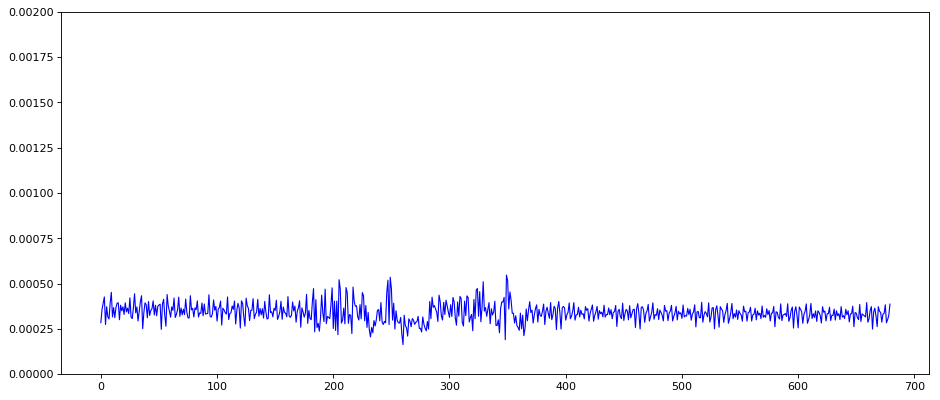

In [27]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(healthy_losses)
plt.ylim(0,0.002)
ax.plot(range(0,size), healthy_losses, '-', color='blue', animated = True, linewidth=1)

In [22]:
#file_ids = spark.sql('select distinct _c1 from df_faulty').rdd.map(lambda row: row._c1).collect()
start = time.time()
for file_id in [149]:
    recording_trimmed = create_trimmed_recording(df_faulty_read_parquet, file_id)
    print("recording_trimmed size: " + str(recording_trimmed.size))
    print ("Staring training on:" + str(file_id))
    train(recording_trimmed)
    print ("Finished training on" + str(file_id) + " after " + str(time.time()-start) + " seconds")

print ("Finished job on after " + str(time.time()-start) + " seconds")
faulty_losses = lossHistory.losses

recording_trimmed size: 970000
Staring training on:149
Train on 4850 samples, validate on 4850 samples
Epoch 1/20
4850/4850 [==============================] - 11s - loss: 0.0011 - val_loss: 7.6748e-04
Epoch 2/20
4850/4850 [==============================] - 11s - loss: 9.4492e-04 - val_loss: 9.0074e-04
Epoch 3/20
4850/4850 [==============================] - 10s - loss: 8.9480e-04 - val_loss: 8.6778e-04
Epoch 4/20
4850/4850 [==============================] - 11s - loss: 7.4849e-04 - val_loss: 7.4949e-04
Epoch 5/20
4850/4850 [==============================] - 10s - loss: 6.7300e-04 - val_loss: 6.9583e-04
Epoch 6/20
4850/4850 [==============================] - 10s - loss: 6.2344e-04 - val_loss: 6.6061e-04
Epoch 7/20
4850/4850 [==============================] - 10s - loss: 5.8891e-04 - val_loss: 6.3160e-04
Epoch 8/20
4850/4850 [==============================] - 10s - loss: 5.5483e-04 - val_loss: 6.0601e-04
Epoch 9/20
4850/4850 [==============================] - 10s - loss: 5.3506e-04 - val_

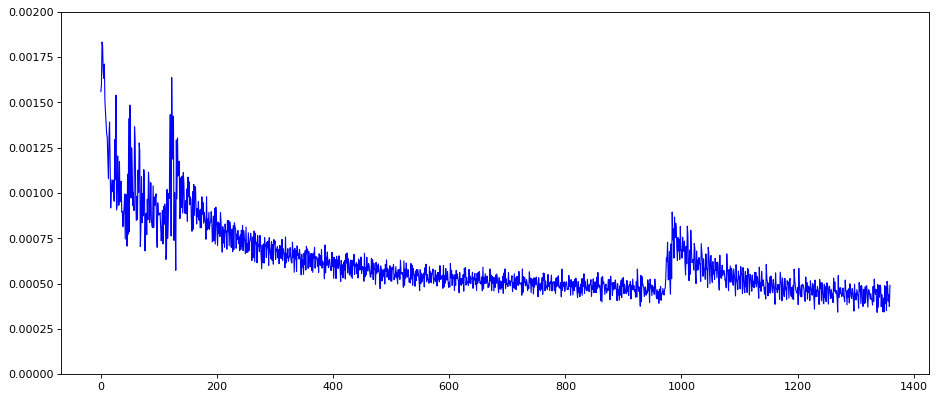

In [26]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(faulty_losses)
plt.ylim(0,0.002)
ax.plot(range(0,size), faulty_losses, '-', color='blue', animated = True, linewidth=1)